# Training notebook for MACE

This notebook shows you how to train a MACE model and is based on the tutorials from the MACE github repository and nff. 



In [3]:
from ase.io import read,write 
import numpy as np 
import matplotlib.pyplot as plt   
from collections import Counter


In [2]:

db = read('../data/w-14.xyz', index=':') # this is how you read all the configurates in the xyz file 

print("Number of configs in database: ", len(db))
print("Number of atoms in each config: ", np.array([len(at) for at in db]))
print("Number of atoms in the smallest config: ", np.min([len(at) for at in db])) #test if database contains isolated atoms
print("Information stored in config.info: \n", db[10].info) #check info
print("Information stored in config.arrays: \n", db[10].arrays)

Number of configs in database:  9693
Number of atoms in each config:  [  1   1   1 ... 135 135 135]
Number of atoms in the smallest config:  1
Information stored in config.info: 
 {'config_type': 'slice_sample', 'virial': array([[-0.8662187 ,  0.92340329, -0.27199288],
       [ 0.92340329, -0.35106052, -0.24708833],
       [-0.27199288, -0.24708833, -0.85291697]])}
Information stored in config.arrays: 
 {'numbers': array([74]), 'positions': array([[0., 0., 0.]]), 'force': array([[0., 0., 0.]])}


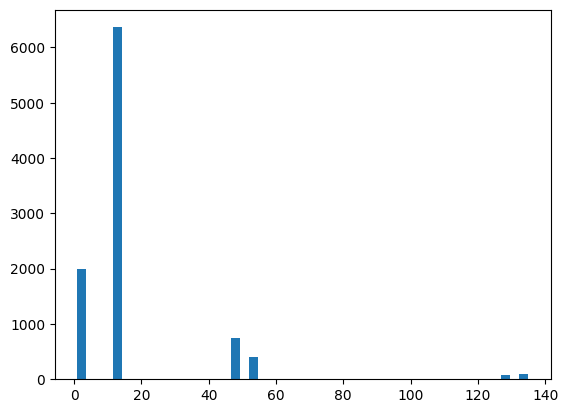

In [9]:
# visualize the spread of our configurations 
plt.hist([len(at) for at in db], bins=50)
plt.show()


In [14]:
# accessing the properties of an atoms object
energy = db[0].get_potential_energy() # this is how you get the potential energy of an atoms object 
forces = db[0].arrays['force'] # this is how you get the forces of an atoms object reliably (sometimes if your calculator is not set up correctly you may get an error when trying to access the forces)
try:
    stress = db[0].get_stress() # gets the stress if it exists 
except:
    stress = None

# other information about the atoms object is usually stored in the info dictionary 
print("Information stored in config.info: \n", db[10].info) #check info
print("Energy: ", energy)
print("Forces: ", forces)
print("Stress: ", stress)


Information stored in config.info: 
 {'config_type': 'slice_sample', 'virial': array([[-0.8662187 ,  0.92340329, -0.27199288],
       [ 0.92340329, -0.35106052, -0.24708833],
       [-0.27199288, -0.24708833, -0.85291697]])}
Energy:  -11.194835125297
Forces:  [[0. 0. 0.]]
Stress:  None


In [20]:
# when training potentials using MACE, you will need to change the name of the energy, force, and stress properties in the atoms object 
# I usually do this by replacing the names with a python script, but if you run your jobs using ase, you can directly set the computed properties
# with something like this atoms.info['REF_energy'] = energy, atoms.arrays['REF_force'] = forces, atoms.info['REF_stress'] = stress

# rename the energy, force, and stress properties 
for atoms in db:
    atoms.info['REF_energy'] = atoms.get_potential_energy()
    atoms.arrays['REF_force'] = atoms.arrays['force']
    try:
        atoms.info['REF_stress'] = atoms.get_stress()
    except:
        atoms.info['REF_stress'] = None

# now we will train a MACE model go here for more information on the MACE model  https://colab.research.google.com/drive/1ZrTuTvavXiCxTFyjBV4GqlARxgFwYAtX 

In [21]:
# before running a model we need to setup our data set 
# we will split our data into training, validation, and testing sets 
# we will use 80% of the data for training, 10% for validation, and 10% for testing 
# we will save the data in the data folder 

# now we will write our configuration file 
train_frac = 0.80
valid_frac = 0.10
test_frac = 0.10

# we will also shuffle the data prior to splitting it 
np.random.seed(42)
np.random.shuffle(db)

# split the data into training, validation, and testing sets without using the split function cause that doesn't exist in ase 
train_data = db[:int(train_frac*len(db))]
valid_data = db[int(train_frac*len(db)):int((train_frac+valid_frac)*len(db))]
test_data = db[int((train_frac+valid_frac)*len(db)):]

# now we write the atoms objects to xyz files in the data folder 
write('../data/w-14_train.xyz', train_data)
write('../data/w-14_valid.xyz', valid_data)
write('../data/w-14_test.xyz', test_data)

# now we write the configuration file 

In [23]:
# test to make sure our files are written correctly 
train_file = read('../data/w-14_train.xyz', index=':')
print(train_file[0].info['REF_energy'])
print(train_file[0].arrays['REF_force'])



-132.3770123362083
[[ 1.844468   -0.21166436  0.19052277]
 [ 0.2145887  -0.09391867 -0.02153316]
 [ 0.21399258 -0.09389837 -0.02152695]
 [ 1.84393471 -0.21188589  0.19075766]
 [-0.02732234 -0.00534111 -0.02963899]
 [ 0.02732234  0.00534111  0.02963899]
 [ 0.02748875  0.00533764  0.02962907]
 [-0.02748875 -0.00533764 -0.02962907]
 [-0.2145887   0.09391867  0.02153316]
 [-1.844468    0.21166436 -0.19052277]
 [-1.84393471  0.21188589 -0.19075766]
 [-0.21399258  0.09389837  0.02152695]]


Below we will write our first configuration file for the MACE model. Refer to the MACE github repository for more information on the different parameters. 


In [30]:
%%writefile config/config-01.yml

model: "MACE"
num_channels: 32
max_L: 0 # the maximum angular order of the model 
r_max: 4.0 # cutoff radius for how far neighbors are considered 
lr: 0.001 # learning rate one of the most important parameters, if your model is jagged, turn this down 
name: "mace01"
model_dir: "MACE_models"
log_dir: "MACE_models"
checkpoints_dir: "MACE_models"
E0s: "average"
results_dir: "MACE_models"
train_file: "../data/w-14_train.xyz"
valid_file: "../data/w-14_valid.xyz"
test_file: "../data/w-14_test.xyz"
energy_key: "REF_energy"
forces_key: "REF_force"
device: cuda
batch_size: 32
max_num_epochs: 50
swa: True
seed: 123


Overwriting config/config-01.yml


In [25]:
# now we will train the model 
import warnings 
warnings.filterwarnings("ignore")
from mace.cli.run_train import main as mace_run_train_main 
import sys
import logging 

# this is a little helper function to run the training script 
def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]
    mace_run_train_main()

In [31]:
# run the training script, this will take a while if you don't have a GPU... 
# if you're running on a cpu, change the device to cpu in the config file, and reduce the size of the training files by a factor of 10
# this took about 11 minutes on an Nvidia RTX 3090 GPU 
train_mace('config/config-01.yml')



2024-11-04 21:07:47.829 INFO: MACE version: 0.3.6
2024-11-04 21:07:47.829 INFO: Configuration: Namespace(config='config/config-01.yml', name='mace01', seed=123, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=3, correlation=3, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=32, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='../data/w-14_train.xyz', valid_file='../data/w-14_val

In [32]:
# now we will test the model 
from mace.cli.eval_configs import main as mace_eval_configs_main 
import sys 


def eval_mace(configs, model, output):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", configs, "--model", model, "--output", output]
    mace_eval_configs_main()

# we will evaluate the model on teh train set and the test set
eval_mace('../data/w-14_train.xyz', 'MACE_models/mace01_run-123_swa.model', 'MACE_models/mace01_train.xyz')
# now we will test the model 
eval_mace('../data/w-14_test.xyz', 'MACE_models/mace01_run-123_swa.model', 'MACE_models/mace01_test.xyz')

INFO:root:Using CPU
INFO:root:Using CPU


In [34]:
eval_data_test = read('MACE_models/mace01_test.xyz', index=':')
eval_data_train = read('MACE_models/mace01_train.xyz', index=':')


In [35]:
# let's take a look at the information stored in the eval_data_test atoms object 
print(eval_data_test[0].info.keys())
print(eval_data_test[0].arrays.keys())

dict_keys(['config_type', 'REF_energy', 'REF_stress', 'MACE_energy'])
dict_keys(['numbers', 'positions', 'force', 'REF_force', 'MACE_forces'])


In [40]:
# we can now compare the predicted forces and energies to the reference forces and energies 
from ase.io import read 
import matplotlib.pyplot as plt 
import numpy as np 

def plot_parity(db, title):
    plt.figure(figsize=(10, 4))
    
    # Energy parity plot
    plt.subplot(1, 2, 1)
    # Normalize energies per atom
    ref_energies = [atoms.info['REF_energy']/len(atoms) for atoms in db]
    pred_energies = [atoms.info['MACE_energy']/len(atoms) for atoms in db]
    
    # Find overall min and max for equal axes
    e_min = min(min(ref_energies), min(pred_energies))
    e_max = max(max(ref_energies), max(pred_energies))
    
    plt.scatter(ref_energies, pred_energies, alpha=0.5)
    plt.plot([e_min, e_max], [e_min, e_max], 'r--')
    plt.xlim(e_min, e_max)
    plt.ylim(e_min, e_max)
    plt.xlabel('Reference Energy (eV/atom)')
    plt.ylabel('Predicted Energy (eV/atom)')
    plt.title(f'{title} - Energy Parity')
    
    # Force parity plot
    plt.subplot(1, 2, 2)
    ref_forces = np.concatenate([atoms.arrays['REF_force'].flatten() for atoms in db])
    pred_forces = np.concatenate([atoms.arrays['MACE_forces'].flatten() for atoms in db])
    
    # Find overall min and max for equal axes
    f_min = min(min(ref_forces), min(pred_forces))
    f_max = max(max(ref_forces), max(pred_forces))
    
    plt.scatter(ref_forces, pred_forces, alpha=0.5, s=1)
    plt.plot([f_min, f_max], [f_min, f_max], 'r--')
    plt.xlim(f_min, f_max)
    plt.ylim(f_min, f_max)
    plt.xlabel('Reference Force (eV/Å)')
    plt.ylabel('Predicted Force (eV/Å)')
    plt.title(f'{title} - Force Parity')
    
    plt.tight_layout()
    
    # Calculate and print RMSEs
    energy_rmse = np.sqrt(np.mean((np.array(ref_energies) - np.array(pred_energies))**2))
    force_rmse = np.sqrt(np.mean((ref_forces - pred_forces)**2))
    print(f'{title} Energy RMSE: {energy_rmse:.3f} eV/atom')
    print(f'{title} Force RMSE: {force_rmse:.3f} eV/Å')

Test Set Energy RMSE: 0.005 eV/atom
Test Set Force RMSE: 0.087 eV/Å
Training Set Energy RMSE: 0.005 eV/atom
Training Set Force RMSE: 0.086 eV/Å


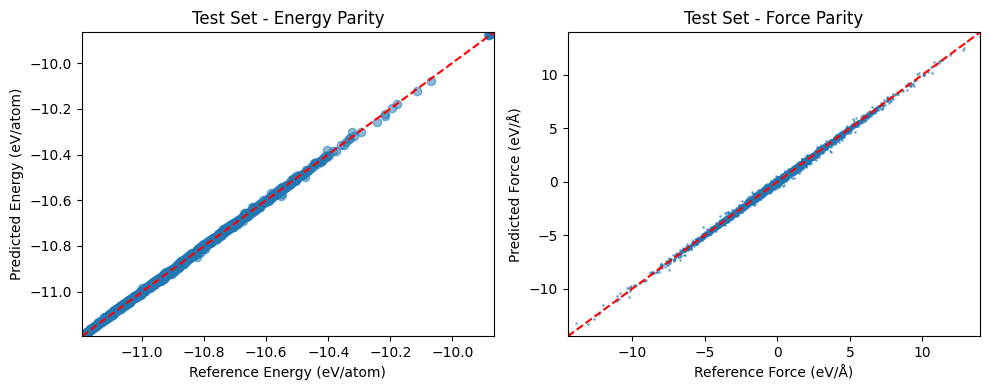

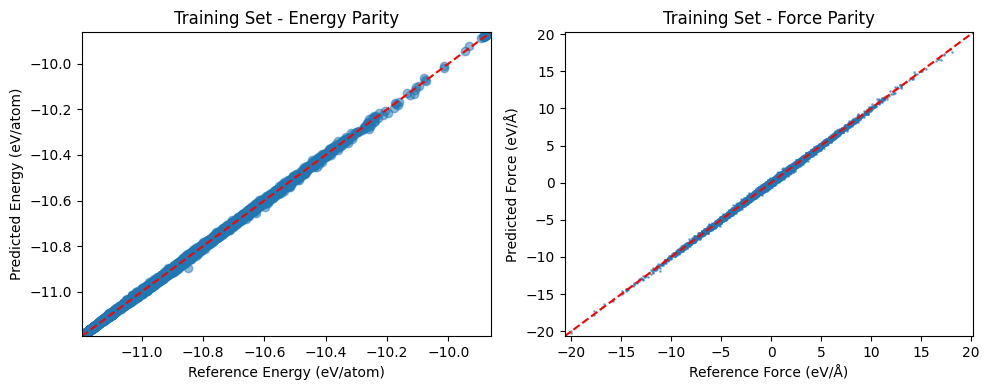

In [41]:
# Usage:
plot_parity(eval_data_test, 'Test Set')
plot_parity(eval_data_train, 'Training Set')
# this is pretty close to a quantum accurate model, but the forces could be a bit better! 

# Generating an ensemble of models 

We would generate an ensemble of models by changing the seed in the config file that we used from before. We make sure that the models are trained on the same data, but with different orders of data being fed into the model, and different initial random weights of the model. 

We can then average the predictions of the models to identify which data-points are the most problematic. 

In [44]:
base_config = """model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0
lr: 0.001
name: "mace_gen_0_model_{:02d}"
model_dir: "MACE_models"
log_dir: "MACE_models"
checkpoints_dir: "MACE_models"
E0s: "average"
results_dir: "MACE_models"
train_file: "../data/w-14_train.xyz"
valid_file: "../data/w-14_valid.xyz"
test_file: "../data/w-14_test.xyz"
energy_key: "REF_energy"
forces_key: "REF_force"
device: cuda
batch_size: 64
max_num_epochs: 50
swa: True
seed: {}"""

# Create 5 different config files with different seeds
for i in range(5):
    seed = i  # Different seed for each model
    config = base_config.format(i+1, seed)
    with open(f'config/w_gen_0_model-{i+1:02d}.yml', 'w') as f: # usually a good idea to designate the generation number and the model number 
        f.write(config)

In [45]:
# now we can train the models skip this unless you have a GPU and 45 minutes to spare
for i in range(5):
    train_mace(f'config/w_gen_0_model-{i+1:02d}.yml')


2024-11-04 21:34:22.957 INFO: MACE version: 0.3.6
2024-11-04 21:34:22.958 INFO: Configuration: Namespace(config='config/w_gen_0_model-01.yml', name='mace_gen_0_model_01', seed=0, log_dir='MACE_models', model_dir='MACE_models', checkpoints_dir='MACE_models', results_dir='MACE_models', downloads_dir='downloads', device='cuda', default_dtype='float64', distributed=False, log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=4.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, pair_repulsion=False, distance_transform='None', interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=3, correlation=3, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='128x0e + 128x1o', num_channels=32, max_L=0, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='../data/w-14_train.xyz', valid_file

Great! Now that we have trained our model and an ensemble of models, we can use the model to select new configurations for future DFT calculations. This will be covered in the run_md.ipynb notebook. 